# QCoDeS example with Textronix DPO 7200xx scopes 


In [1]:
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

from qcodes.instrument_drivers.tektronix.DPO7200xx import TektronixDPO7000xx

In [2]:
tek = TektronixDPO7000xx("tek3", "TCPIP0::10.193.36.56::inst0::INSTR")

Connected to: TEKTRONIX DPO72004C (serial:C600651, firmware:CF:91.1CT FV:10.8.3 Build 3) in 0.47s


In [3]:
initialise_database()
experiment = new_experiment(name='DPO_72000_example', sample_name="no sample")

## Aqcuiring traces 

In [4]:
# First, determine the number of samples we wish to acquire
tek.channel[0].set_trace_length(10000)
# alternatively, we can set the time over which we 
# wish to acquire a trace (uncomment the following line): 
# tek.channel[0].set_trace_time(4E-3)

Starting experimental run with id: 134


([<matplotlib.axes._subplots.AxesSubplot at 0x1e156cce4a8>,
 [None, None])

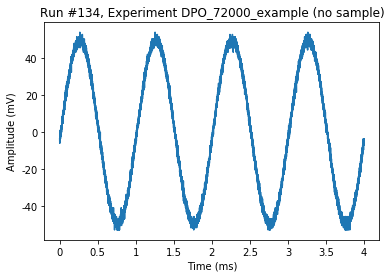

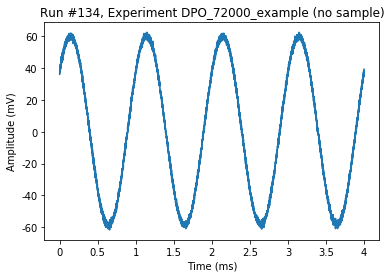

In [5]:
meas = Measurement(exp=experiment)
meas.register_parameter(tek.channel[0].waveform.trace)
meas.register_parameter(tek.channel[1].waveform.trace)

with meas.run() as datasaver:
    for i in [0, 1]:
        datasaver.add_result(
            (tek.channel[i].waveform.trace_axis, tek.channel[i].waveform.trace_axis()),
            (tek.channel[i].waveform.trace, tek.channel[i].waveform.trace())
        )

    dataid = datasaver.run_id

plot_by_id(dataid)

## Changing the waveform format 

If we wish, we can change the way in which data is retrieved from the instrument, which can enhance the precision of the data and the speed to retrieval. 

We do this through the 'waveform' module on the main driver (e.g. `tek.waveform`) as opposed to the 'waveform' module on a channel (e.g. `tek.channel[0].waveform`). We have this distinction because 

In [6]:
tek.waveform.data_format()

'signed_integer'

In [7]:
tek.waveform.is_big_endian()

True

In [8]:
tek.waveform.bytes_per_sample()

1

In [9]:
tek.waveform.is_binary()

True

In [9]:
tek.measurement[0].source1("CH1")
tek.measurement[0].type("frequency")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

998.1368112856 Hz


In [10]:
tek.measurement[0].type("amplitude")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.09840000391006 V


In [11]:
tek.measurement[0].source1("CH2")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.11680000826716 V


In [12]:
tek.measurement[0].source1("CH1")
tek.measurement[0].source2("CH2")
tek.measurement[0].type("phase")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

-38.484 °


# Future work 

The DPO7200xx scopes have support for mathematical operations. An example of a math operation is a spectral analysis. Although the current QCoDeS driver does not support these operations, the way the driver code has been factored should make it simple to add support if future need arrises. 

An example: we manually add a sprectrum analysis by selecting "math" -> "advanced spectral" from the oscilloscope menu in the front display of the instrument. After manual creation, we can retrieve spectral data with the driver as follows: 

In [14]:
from qcodes.instrument_drivers.tektronix.DPO7200xx import TekronixDPOWaveform

In [15]:
math_channel = TekronixDPOWaveform(tek, "math", "MATH1")

Starting experimental run with id: 131


([<matplotlib.axes._subplots.AxesSubplot at 0x1bbf30c8438>], [None])

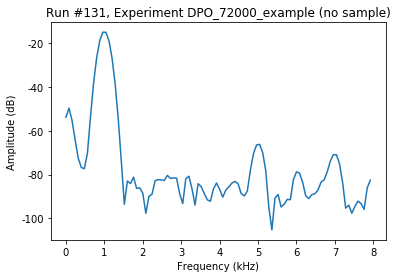

In [17]:
meas = Measurement(exp=experiment)
meas.register_parameter(math_channel.trace)

with meas.run() as datasaver:

    datasaver.add_result(
        (math_channel.trace_axis, math_channel.trace_axis()),
        (math_channel.trace, math_channel.trace())
    )

    dataid = datasaver.run_id

plot_by_id(dataid)

In order to add full support for spectral analysis, we need to subclass `TekronixDPOWaveform` and add parameters in the subclass which are specifically relevant to spectral analysis. For example, we will need a method to create a spectral analysis function and we need parameters which get/set frequency spans. 

In [26]:
["a"] + ['B']

['a', 'B']